# Other attempts

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Code-for-retrieving-genre-labels-from-Spotipy-API" data-toc-modified-id="Code-for-retrieving-genre-labels-from-Spotipy-API-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Code for retrieving genre labels from Spotipy API</a></span></li><li><span><a href="#Clustering-and-PCA" data-toc-modified-id="Clustering-and-PCA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Clustering and PCA</a></span></li><li><span><a href="#Models-for-predicting-position-of-track-in-playlist" data-toc-modified-id="Models-for-predicting-position-of-track-in-playlist-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Models for predicting position of track in playlist</a></span></li><li><span><a href="#Recommender-system-model" data-toc-modified-id="Recommender-system-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Recommender system model</a></span></li></ul></div>

In [9]:
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Code for retrieving genre labels from Spotipy API

We registered for and created a credential for our specific application/project

In [2]:
spotify = spotipy.Spotify()

client_credentials_manager = SpotifyClientCredentials(client_id='9f4add2b5f494ce8b926497a96bf6d13', client_secret='43259646240a4b99a54feed393730d6f')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

We read in one of the .csv files, for computational concerns, and retrieve the genre labels.

In [7]:
first_dataframe = pd.read_csv('songs999.csv')

In [ ]:
first_dataframe['genre'] = ''
for i in range(3000): #len(first_dataframe['artist_uri'])
    first_dataframe.reset_index(drop=True, inplace=True)
    album_str = sp.artist(first_dataframe['artist_uri'][i])
    json_obj = json.dumps(album_str)
    if '[]' != str(json.loads(json_obj)['genres']):
        if 'classical' in str(json.loads(json_obj)['genres']):
            first_dataframe['genre'][i] = "Classical"
        elif 'soundtrack' in str(json.loads(json_obj)['genres']):
            first_dataframe['genre'][i] = "Soundtrack"
        else:
            first_dataframe['genre'][i] = json.loads(json_obj)['genres']
    else:
        first_dataframe.drop(i, inplace=True)

In [5]:
first_dataframe.head()

,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,genre
0,0,0,Yiruma,spotify:track:7fnqltLx83HsYLQajzCYRk,spotify:artist:0fauHpmSHwodVYIjTqOGHz,River Flows In You,spotify:album:0vIR7YccgfLA1f5wcXZa4Z,185013,River Flows In You,Classical
1,0,1,Frédéric Chopin,spotify:track:3w8507pR0Ncycrol0ZJOwP,spotify:artist:7y97mc3bZRFXzT2szRM4L4,Ballade No. 4 in F minor Op. 52,spotify:album:2ML75R6Z1LEFgPNZS0Ce3D,676000,The Best of Chopin,Classical
2,0,3,Johann Sebastian Bach,spotify:track:48BSXfxyLLxDIp934Is2A9,spotify:artist:5aIqB5nVVvmFsvSdExz408,"Cello Suite No. 1 in G Major, BWV 1007: I. Pre...",spotify:album:2cj4D33pmIvDCiDYWg80Nj,132120,"Bach, J.S.: 6 Suites for Solo Cello, Bwv 1007-...",
3,0,4,Hans Zimmer,spotify:track:4aW4Dpz3gpb619hBXDrFUa,spotify:artist:0YC192cP3KPCRWx8zr8MfZ,"Honor [Main Title Theme From ""The Pacific""]",spotify:album:0NH1WrtzRBlZS1VJX2XnXr,176586,The Pacific (Music From the HBO Miniseries),Soundtrack
4,0,5,Hans Zimmer,spotify:track:79ch1KhwRkS6aRHqcY3uST,spotify:artist:0YC192cP3KPCRWx8zr8MfZ,Landing Peleliu,spotify:album:0NH1WrtzRBlZS1VJX2XnXr,202560,The Pacific (Music From the HBO Miniseries),Soundtrack


In [6]:
first_dataframe[first_dataframe.genre.apply(lambda x: 'pop' in x)]['genre']

25     [dance pop, hip hop, hip pop, neo soul, new ja...
32                [edm, electropop, pop, tropical house]
38     [auckland indie, australian pop, dance pop, el...
40     [electropop, indie electropop, indie pop, indi...
41     [auckland indie, australian pop, dance pop, el...
                             ...                        
961    [dance pop, electropowerpop, emo, pop, pop rap...
962    [dance pop, danish pop, electropop, indie pop,...
968    [dance pop, edm, electropop, indie poptimism, ...
973    [electropop, indie electropop, indie poptimism...
974    [dance pop, hip hop, hip pop, pop, pop rap, r&...
Name: genre, Length: 255, dtype: object

Next, we retriece the audio features:

In [ ]:
first_dataframe['acousticness'] = ''
first_dataframe['duration_ms'] = ''
first_dataframe['duration_ms'] = ''
first_dataframe['energy'] = ''
first_dataframe['liveness'] = ''
first_dataframe['loudness'] = ''
first_dataframe['tempo'] = ''
first_dataframe['valence'] = ''
first_dataframe['danceability'] = ''
first_dataframe['speechiness'] = ''

In [ ]:
for i in range(len(first_dataframe['track_uri'])):
    json_obj = json.dumps(sp.audio_features(first_dataframe['track_uri'][i]))
    first_dataframe['danceability'][i] = json.loads(json_obj)[0]['danceability']
    first_dataframe['speechiness'][i] = json.loads(json_obj)[0]['speechiness']
    first_dataframe['acousticness'][i] = json.loads(json_obj)[0]['acousticness']
    first_dataframe['duration_ms'][i] = json.loads(json_obj)[0]['duration_ms']
    first_dataframe['energy'][i] = json.loads(json_obj)[0]['energy']
    first_dataframe['liveness'][i] = json.loads(json_obj)[0]['liveness']
    first_dataframe['loudness'][i] = json.loads(json_obj)[0]['loudness']
    first_dataframe['tempo'][i] = json.loads(json_obj)[0]['tempo']
    first_dataframe['valence'][i] = json.loads(json_obj)[0]['valence']

In [ ]:
first_dataframe.to_csv('initial_feature_data_songs999.csv')

## Clustering and PCA

In [10]:
songs_df = pd.read_csv('initial_feature_data_songs999.csv')
del songs_df['Unnamed: 0']
songs_df.head()

,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,acousticness,energy,liveness,loudness,tempo,valence,danceability,speechiness
0,0,0,Yiruma,spotify:track:7fnqltLx83HsYLQajzCYRk,spotify:artist:0fauHpmSHwodVYIjTqOGHz,River Flows In You,spotify:album:0vIR7YccgfLA1f5wcXZa4Z,185013,River Flows In You,0.988,0.2070,0.0880,-21.487,144.547,0.1090,0.320,0.0512
1,0,1,Frédéric Chopin,spotify:track:3w8507pR0Ncycrol0ZJOwP,spotify:artist:7y97mc3bZRFXzT2szRM4L4,Ballade No. 4 in F minor Op. 52,spotify:album:2ML75R6Z1LEFgPNZS0Ce3D,676000,The Best of Chopin,0.993,0.1050,0.1030,-24.507,70.014,0.0377,0.270,0.0439
2,0,2,Alexander Pitamic,spotify:track:59E6rPql7W8q2sodZpg1qQ,spotify:artist:4TuTJcUBhYyPoHYTSQzGAM,"Serenade für Streicher Nr. 13, G-Dur, KV 525: ...",spotify:album:3V8JHEeOhi7Z765C6v3Pqr,391000,"Wolfgang Amadeus Mozart: Sinfonie Nr. 29, A-Du...",0.952,0.0763,0.1000,-20.524,122.174,0.4100,0.544,0.0505
3,0,3,Johann Sebastian Bach,spotify:track:48BSXfxyLLxDIp934Is2A9,spotify:artist:5aIqB5nVVvmFsvSdExz408,"Cello Suite No. 1 in G Major, BWV 1007: I. Pre...",spotify:album:2cj4D33pmIvDCiDYWg80Nj,132120,"Bach, J.S.: 6 Suites for Solo Cello, Bwv 1007-...",0.990,0.2130,0.0859,-20.577,79.423,0.6170,0.341,0.0715
4,0,4,Hans Zimmer,spotify:track:4aW4Dpz3gpb619hBXDrFUa,spotify:artist:0YC192cP3KPCRWx8zr8MfZ,"Honor [Main Title Theme From ""The Pacific""]",spotify:album:0NH1WrtzRBlZS1VJX2XnXr,176587,The Pacific (Music From the HBO Miniseries),0.335,0.2760,0.1100,-14.830,68.619,0.0575,0.190,0.0346


In [11]:
songs_df.describe()

,pid,pos,duration_ms,acousticness,energy,liveness,loudness,tempo,valence,danceability,speechiness
count,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000
mean,20.778898,62.110866,232801.359370,0.224359,0.666765,0.197051,-7.328659,122.522027,0.496176,0.562059,0.079370
std,12.706229,54.751846,78722.583095,0.273712,0.218357,0.166337,3.780474,29.790286,0.250990,0.168482,0.080733
min,0.000000,0.000000,14213.000000,0.000002,0.007610,0.015700,-33.350000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,19.000000,190302.500000,0.013150,0.529000,0.094950,-8.703500,99.865500,0.294000,0.446000,0.035000
50%,20.000000,46.000000,221623.000000,0.095800,0.697000,0.131000,-6.478000,120.033000,0.486000,0.573000,0.047600
75%,34.000000,92.000000,258940.000000,0.362500,0.843000,0.254000,-4.907000,141.927000,0.697500,0.686000,0.082550
max,44.000000,233.000000,941360.000000,0.993000,0.997000,0.994000,1.586000,219.297000,0.990000,0.967000,0.750000


Here, we make the decision not to scale the pid and pos columns, given that the ordering of the columns is important.

In [12]:
num_vars = songs_df.drop(['pid', 'pos', 'artist_name', 'track_uri', 'artist_uri', 'track_name', 'album_uri', 'album_name'], axis=1)

In [13]:
# Fit the scaler on the training data
scaler = StandardScaler().fit(num_vars)

normalize_scaler = MinMaxScaler().fit(num_vars)

# Scale both the test and training data. 
new_scaled_df = pd.DataFrame(scaler.transform(num_vars), columns = num_vars.columns)

new_scaled_df = pd.DataFrame(normalize_scaler.transform(new_scaled_df), columns = num_vars.columns)

In [14]:
pca = PCA().fit(new_scaled_df)
pca_2d = pca.transform(new_scaled_df)
pcaX_train_df = pd.DataFrame(pca_2d)

In [15]:
list_of_audio_features = ['acousticness', 'energy', 'liveness', 'loudness', 'tempo', 'valence', 'danceability', 'speechiness']

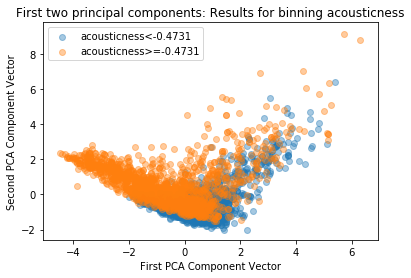

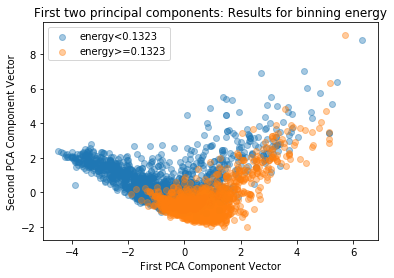

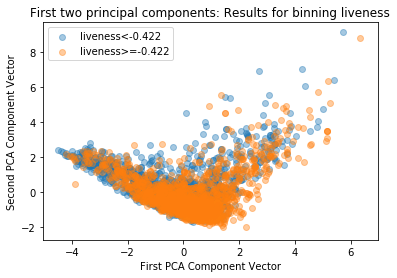

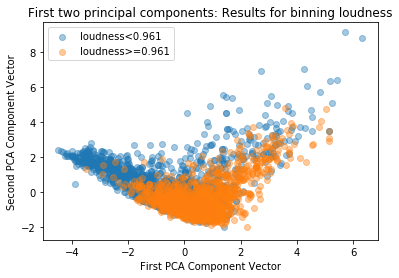

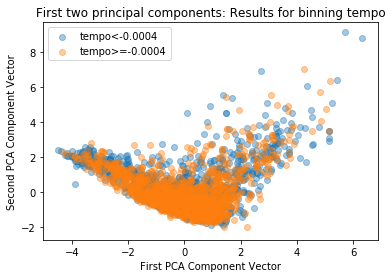

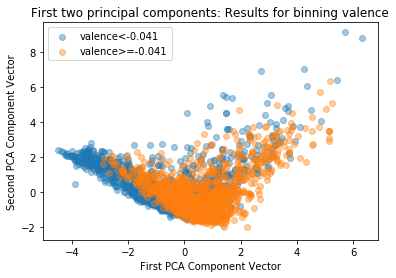

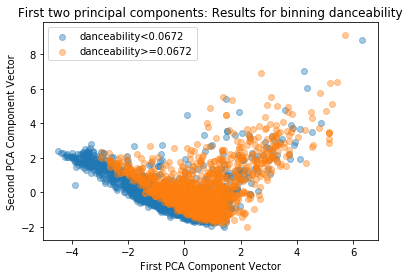

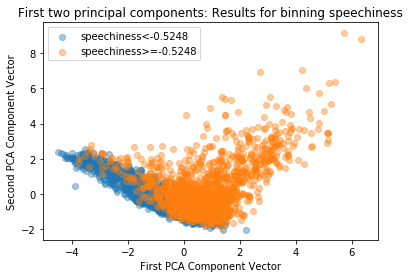

In [16]:
for column_plot in ['acousticness', 'energy', 'liveness', 'loudness', 'tempo', 'valence', 'danceability', 'speechiness']:
    
    cut_off = round(np.median(new_scaled_df[column_plot]), 4)
    df_y_train = pd.DataFrame(new_scaled_df[column_plot]).set_index(pcaX_train_df.index)
    
    plt.figure()
    plt.scatter(pcaX_train_df.loc[df_y_train[column_plot] < cut_off, 0], pcaX_train_df.loc[df_y_train[column_plot] < cut_off, 1], alpha=0.4, label= str(column_plot) + "<" + str(cut_off))
    plt.scatter(pcaX_train_df.loc[df_y_train[column_plot] >= cut_off, 0], pcaX_train_df.loc[df_y_train[column_plot] >= cut_off, 1], alpha=0.4, label= str(column_plot) + ">=" + str(cut_off))

    plt.xlabel("First PCA Component Vector")
    plt.ylabel("Second PCA Component Vector")
    plt.title("First two principal components: Results for binning " + str(column_plot))
    plt.legend();

In [17]:
print("Variance explained by top two components", pca.explained_variance_ratio_[0:2])

Variance explained by top two components [0.31468733 0.22762172]


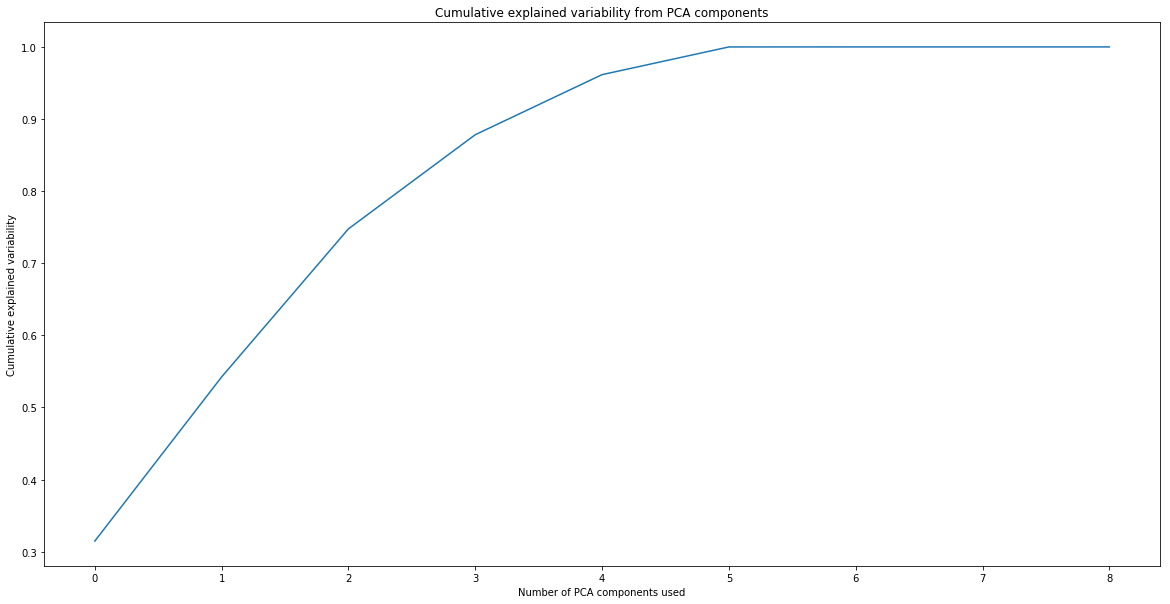

In [18]:
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of PCA components used")
plt.ylabel("Cumulative explained variability")
plt.title("Cumulative explained variability from PCA components");

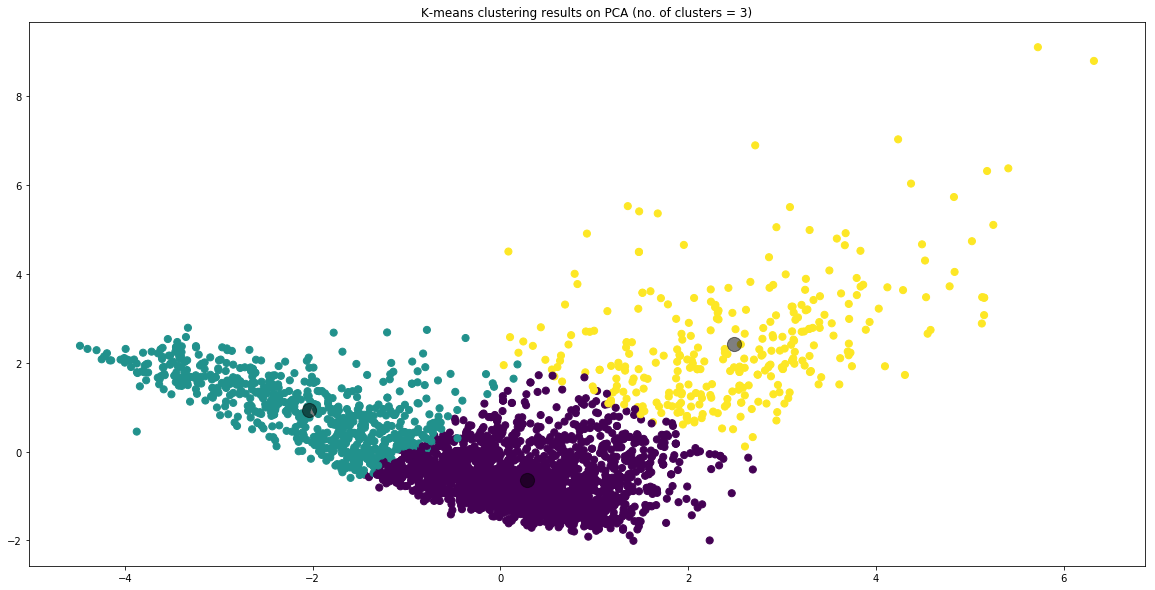

In [19]:
from sklearn.cluster import KMeans
plt.figure(figsize=(20,10))
kmeans = KMeans(n_clusters=3)
kmeans.fit(pcaX_train_df)
y_kmeans = kmeans.predict(pcaX_train_df)

plt.scatter(pcaX_train_df[0], pcaX_train_df[1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title("K-means clustering results on PCA (no. of clusters = 3)");

In [20]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(new_scaled_df)
y_kmeans = kmeans.predict(new_scaled_df)
y_kmeans

array([0, 0, 0, ..., 2, 2, 1])

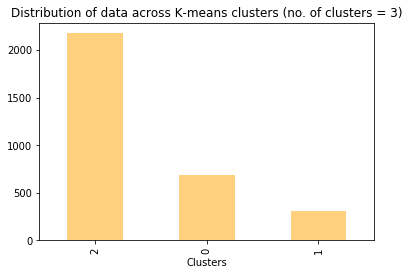

In [21]:
pd.value_counts(y_kmeans).plot(kind="bar", color="orange", alpha = 0.5)
plt.title("Distribution of data across K-means clusters (no. of clusters = 3)")
plt.xlabel("Clusters");

In [22]:
print("Cluster 0: ", songs_df.iloc[6]['track_name'])
print("Cluster 1: ", songs_df.iloc[9]['track_name'])
print("Cluster 2: ", songs_df.iloc[20]['track_name'])

Cluster 0:  Give 'Em a Chance
Cluster 1:  Requiem For A Tower
Cluster 2:  Fog Bound - From "Pirates of the Caribbean: The Curse Of the Black Pearl"/Score


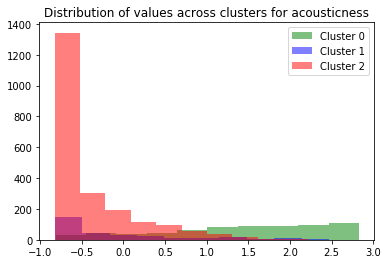

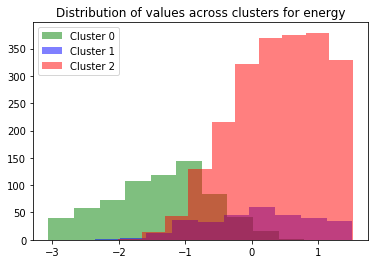

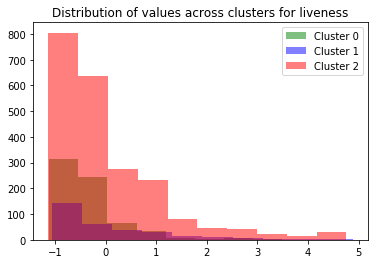

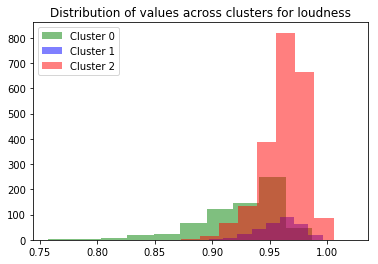

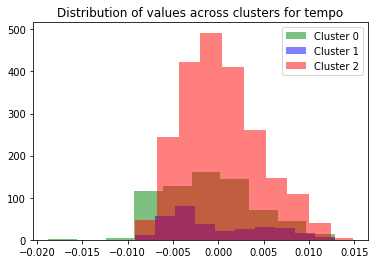

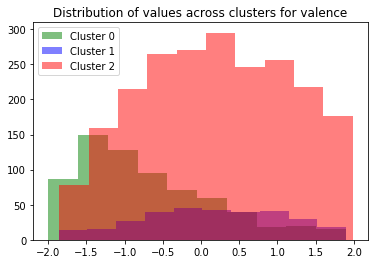

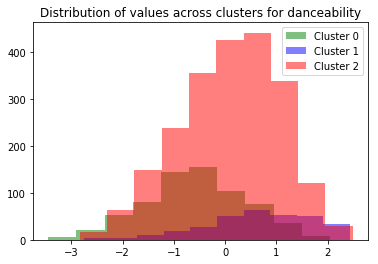

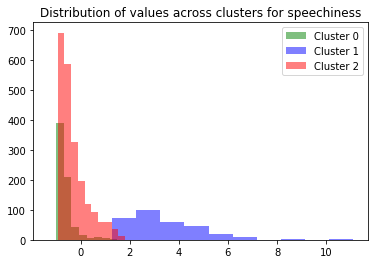

In [23]:
for i in list_of_audio_features:
    plt.figure()
    plt.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 0, str(i)], color="green", alpha=0.5, label="Cluster 0")
    plt.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 1, str(i)], color="blue", alpha=0.5, label="Cluster 1")
    plt.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 2, str(i)], color="red", alpha=0.5, label="Cluster 2")
    plt.legend();
    plt.title("Distribution of values across clusters for " + str(i))

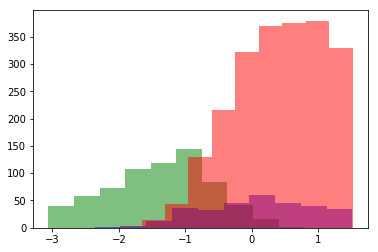

In [24]:
plt.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 0, 'energy'], color="green", alpha=0.5)
plt.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 1, 'energy'], color="blue", alpha=0.5)
plt.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 2, 'energy'], color="red", alpha=0.5);

## Models for predicting position of track in playlist

In [25]:
X_train, X_test, y_train, y_test = train_test_split(new_scaled_df, songs_df['pos'], test_size=0.33, random_state=42)

In [26]:
logreg = LogisticRegression(C=100000, fit_intercept=False, solver='lbfgs', max_iter=10000)
logreg.fit(X_train, y_train)
logreg.predict(X_train)
logreg.score(X_test, y_test)

0.009541984732824428

In [27]:
linearreg = LinearRegression()
linearreg.fit(X_train, y_train)
linearreg.score(X_test, y_test)

0.027149688734026678